In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import os

# Load dataset
filepath = 'Amazon_Sale_Report.csv'
data = pd.read_csv(filepath, low_memory=False)
print("Data Loaded Successfully")
print("Columns in the dataset:", data.columns)

# Preprocess data
# Drop unnecessary columns
data.drop(columns=['Unnamed: 22', 'fulfilled-by'], errors='ignore', inplace=True)
data.drop_duplicates(inplace=True)

# Convert `Order ID` and `SKU` to strings
data['Order ID'] = data['Order ID'].astype(str)
data['SKU'] = data['SKU'].astype(str)

# Handle missing values in numeric columns
if 'Amount' in data.columns:
    data['Amount'] = data['Amount'].fillna(data['Amount'].mean())
if 'Qty' in data.columns:
    data['Qty'] = data['Qty'].fillna(0).astype(int)

# Ensure proper date parsing
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], format='%m-%d-%y', errors='coerce')
    data = data.dropna(subset=['Date'])  # Drop rows with invalid dates

# Feature engineering: Calculate `Sales`
if 'Qty' in data.columns and 'Amount' in data.columns:
    data['Sales'] = data['Qty'] * data['Amount']
else:
    print("Error: Missing required columns ('Qty' or 'Amount') to calculate 'Sales'.")

# Set 'Date' as index
data.set_index('Date', inplace=True)

# Add lag features and rolling averages to capture temporal patterns
data['Sales_Lag_1'] = data['Sales'].shift(1)
data['Sales_Lag_2'] = data['Sales'].shift(2)
data['Rolling_Mean_2'] = data['Sales'].rolling(window=2).mean()
data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

# Select specific SKUs to analyze
product_skus = ['SET389-KR-NP-S', 'PRO123-AB-XY-T']  # Example SKUs

# Prepare directory for output
output_dir = "/content/reports"
os.makedirs(output_dir, exist_ok=True)

# Forecasting setup
r2_scores = {}
mae_scores = {}
mse_scores = {}

for product_sku in product_skus:
    print(f"Processing SKU: {product_sku}")

    # Filter data for specific SKU
    product_data = data[data['SKU'] == product_sku]

    if product_data.empty:
        print(f"No data for SKU: {product_sku}")
        continue

    product_data = product_data.resample('W').sum()  # Weekly aggregation

    if len(product_data) < 3:
        print(f"Insufficient data for SKU: {product_sku}")
        continue

    features = ['Sales_Lag_1', 'Sales_Lag_2', 'Rolling_Mean_2']
    X = product_data[features]
    y = product_data['Sales']

    # Split data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Model training
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Evaluation
    r2_scores[product_sku] = r2_score(y_test, predictions)
    mae_scores[product_sku] = mean_absolute_error(y_test, predictions)
    mse_scores[product_sku] = mean_squared_error(y_test, predictions)

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, predictions, label='Predicted', color='orange')
    plt.title(f"Forecast for {product_sku}")
    plt.legend()
    plot_path = os.path.join(output_dir, f"{product_sku}_forecast.png")
    plt.savefig(plot_path)
    plt.close()
    plt.show()

# Displaying results in a notebook
for sku in product_skus:
    r2 = r2_scores.get(sku, "N/A")
    mae = mae_scores.get(sku, "N/A")
    mse = mse_scores.get(sku, "N/A")
    print(f"Results for SKU {sku}: R²={r2}, MAE={mae}, MSE={mse}")


Data Loaded Successfully
Columns in the dataset: Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')
Processing SKU: SET389-KR-NP-S
Processing SKU: PRO123-AB-XY-T
No data for SKU: PRO123-AB-XY-T
Results for SKU SET389-KR-NP-S: R²=-0.01752745984796511, MAE=275.8533333333333, MSE=94947.52233333333
Results for SKU PRO123-AB-XY-T: R²=N/A, MAE=N/A, MSE=N/A


In [9]:
%pip install numpy pandas matplotlib statsmodels
%pip install apyori




Note: you may need to restart the kernel to use updated packages.


Could not find platform independent libraries <prefix>


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=8f27eff30e5926006e7e4f0fc68a4c5838fb18274c2efc06917cb602cff49cba
  Stored in directory: c:\users\pcn\appdata\local\pip\cache\wheels\7f\49\e3\42c73b19a264de37129fadaa0c52f26cf50e87de08fb9804af
Successfully built apyori
Note: you may need to restart the kernel to use updated packages.


Could not find platform independent libraries <prefix>


Data Loaded Successfully
Columns in the dataset: Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

Analyzing Sales Trends...


C:\Users\PCN\AppData\Local\Temp\ipykernel_44628\1886650508.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data['Sales'].resample('M').sum()


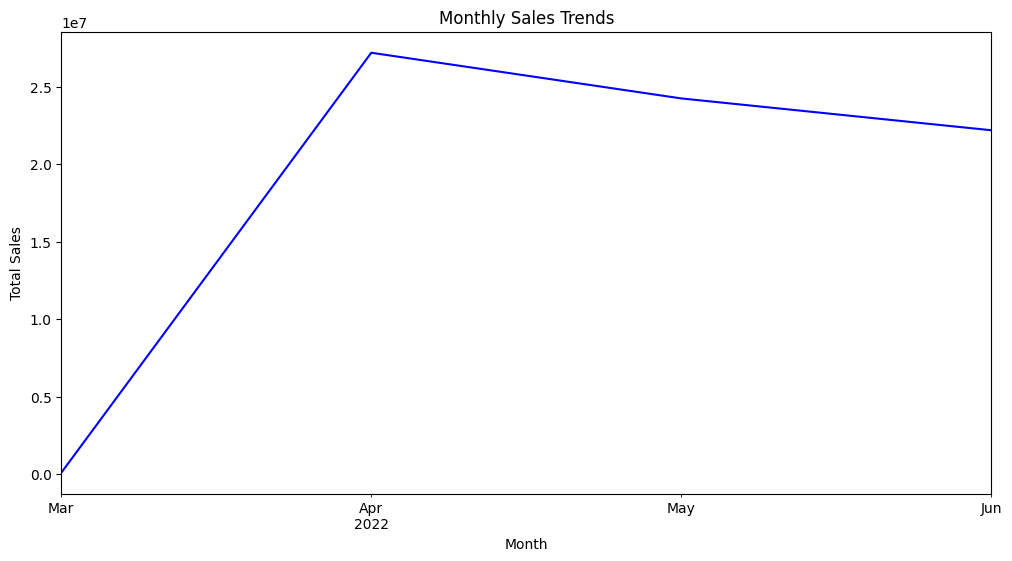

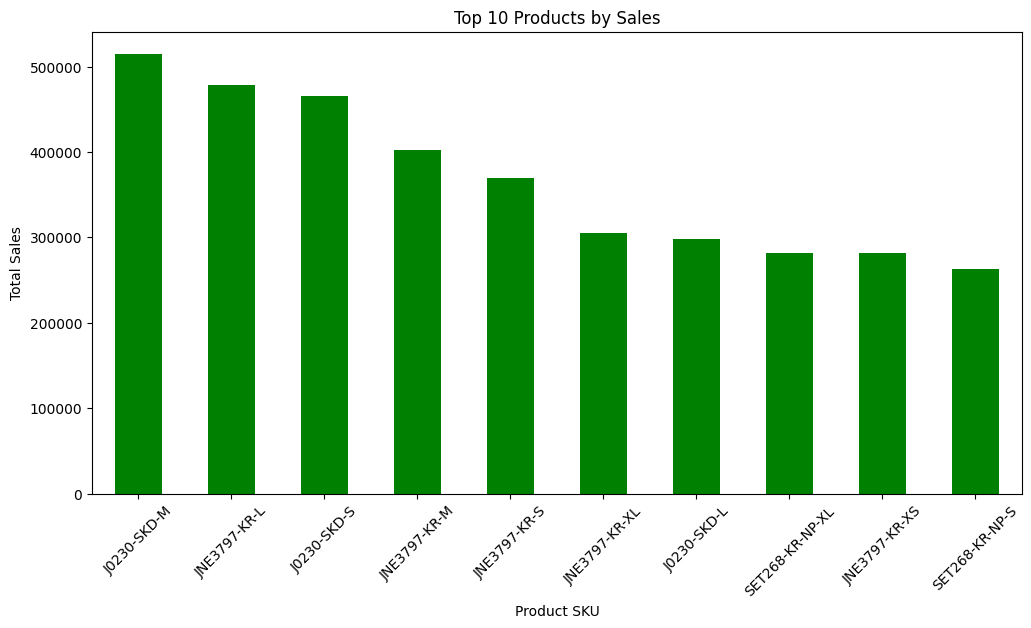

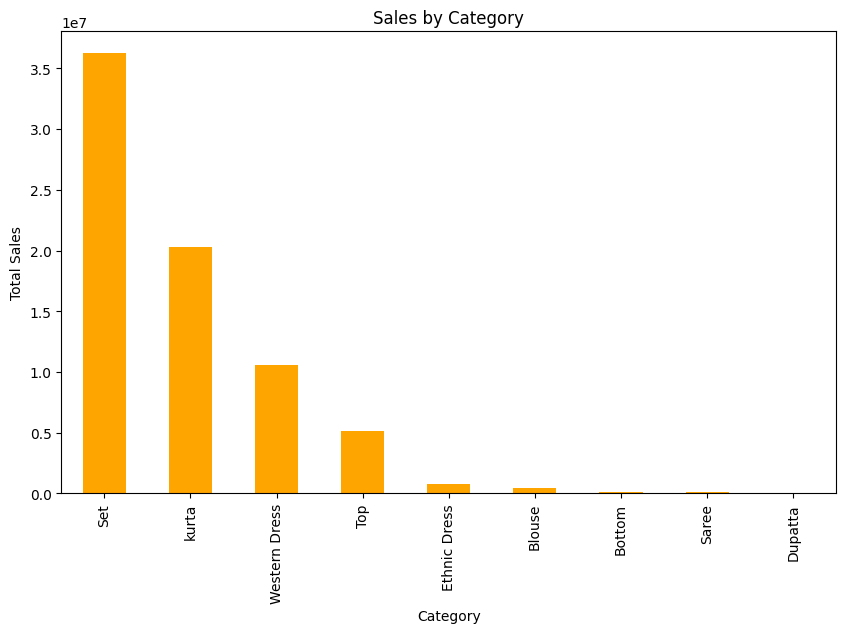


Visualizing Top 10 Selling Sizes...


C:\Users\PCN\AppData\Local\Temp\ipykernel_44628\1886650508.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sizes.index, y=top_sizes.values, palette="viridis")


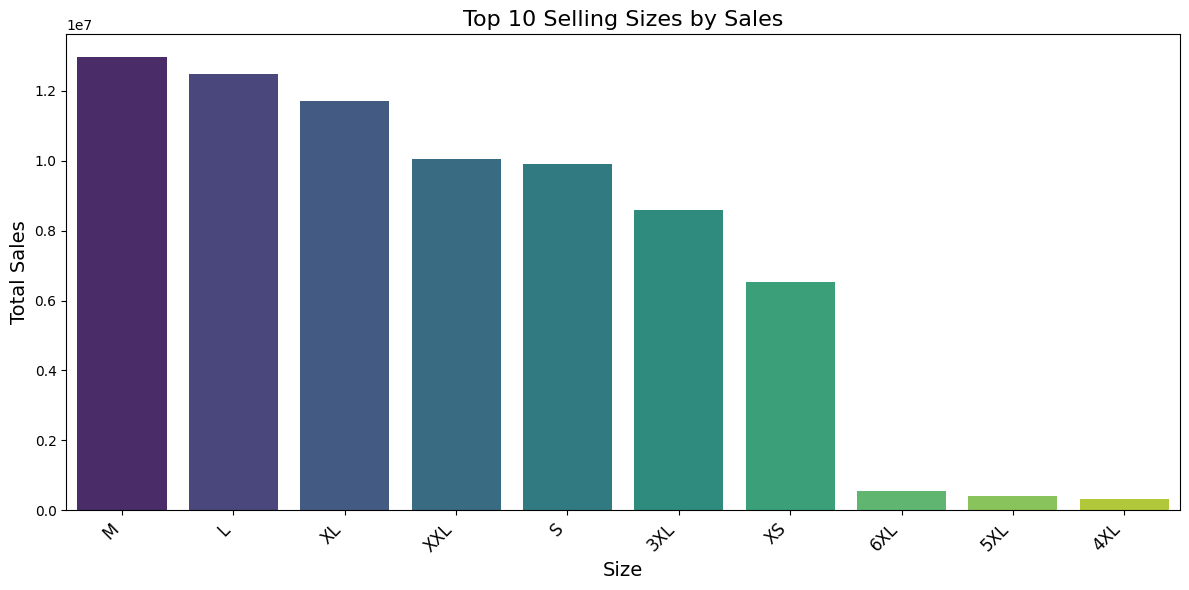


Performing Seasonal Decomposition...

Generating Association Rules...


C:\Users\PCN\AppData\Local\Temp\ipykernel_44628\1886650508.py:118: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data['Sales'].resample('M').sum()
2024-12-28 01:04:29,711 - INFO - Model trained successfully with R^2: 0.43058836607097495, MAE: 441.99333333333334, MSE: 478196.44546666666


Top Association Rules:

Forecasting Demand for Multiple Products...

Forecasting Demand for Product SKU: SET389-KR-NP-S
                       Order ID                        Status Fulfilment  \
Date                                                                       
2022-04-30  405-8078784-5731545                     Cancelled   Merchant   
2022-04-27  408-9553867-3715507  Shipped - Delivered to Buyer   Merchant   
2022-04-24  408-7468849-2134719  Shipped - Delivered to Buyer   Merchant   
2022-04-20  406-8338408-6778764                     Cancelled   Merchant   
2022-04-19  405-2959500-2916317  Shipped - Delivered to Buyer   Merchant   

           ship-service-level   Style             SKU Category Size  \
Date                                                                  
2022-04-30           Standard  SET389  SET389-KR-NP-S      Set    S   
2022-04-27           Standard  SET389  SET389-KR-NP-S      Set    S   
2022-04-24           Standard  SET389  SET389-KR-NP-S      Set 

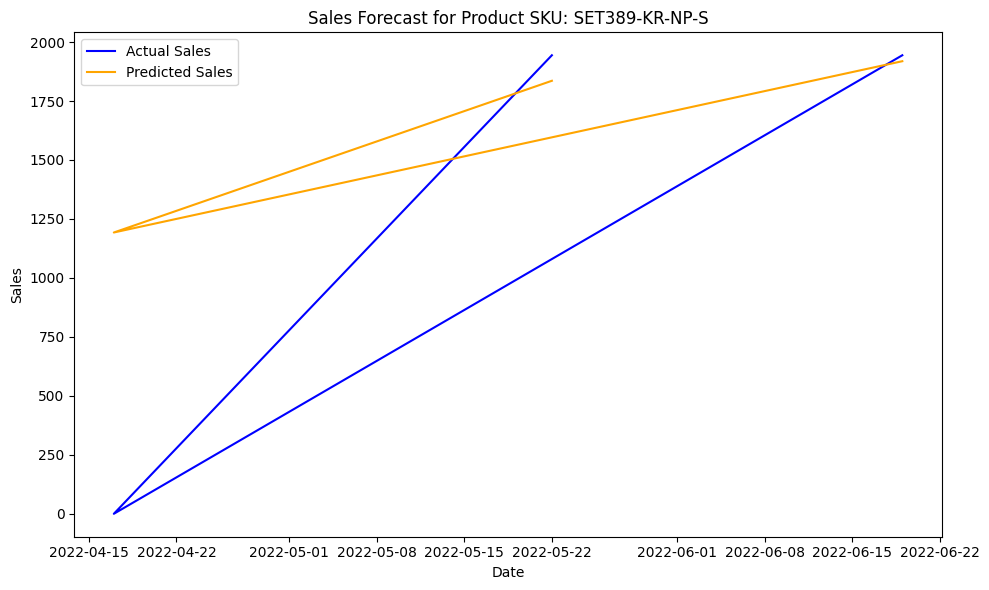


Forecasting Demand for Product SKU: PRO123-AB-XY-T
Empty DataFrame
Columns: [Order ID, Status, Fulfilment, ship-service-level, Style, SKU, Category, Size, ASIN, Courier Status, Qty, Amount, ship-city, ship-state, ship-postal-code, promotion-ids, B2B, Sales, DayOfWeek, is_weekend, Quarter]
Index: []

[0 rows x 21 columns]
No data found for SKU: PRO123-AB-XY-T

Forecasting Demand for Product SKU: DEL456-GH-WX-Z
Empty DataFrame
Columns: [Order ID, Status, Fulfilment, ship-service-level, Style, SKU, Category, Size, ASIN, Courier Status, Qty, Amount, ship-city, ship-state, ship-postal-code, promotion-ids, B2B, Sales, DayOfWeek, is_weekend, Quarter]
Index: []

[0 rows x 21 columns]
No data found for SKU: DEL456-GH-WX-Z


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from apyori import apriori
import logging

def load_data(filepath):
    """
    Load dataset and display basic information.
    """
    data = pd.read_csv(filepath, low_memory=False)
    print("Data Loaded Successfully")
    print("Columns in the dataset:", data.columns)
    return data

def preprocess_data(data):
    """
    Preprocess the data by handling missing values, correcting data types,
    and ensuring compatibility for analysis.
    """
    # Drop unnecessary columns
    data.drop(columns=['Unnamed: 22', 'fulfilled-by'], errors='ignore', inplace=True)
    data.drop_duplicates(inplace=True)

    # Convert `Order ID` and `SKU` to strings
    data['Order ID'] = data['Order ID'].astype(str)
    data['SKU'] = data['SKU'].astype(str)

    # Handle missing values in numeric columns
    data['Amount'] = data['Amount'].fillna(data['Amount'].mean())
    data['Qty'] = data['Qty'].fillna(0).astype(int)

    # Ensure proper date parsing
    data['Date'] = pd.to_datetime(data['Date'], format='%m-%d-%y', errors='coerce')
    data = data.dropna(subset=['Date'])  # Drop rows with invalid dates

    # Feature engineering: Calculate `Sales`
    data['Sales'] = data['Qty'] * data['Amount']

    # Add additional features
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['is_weekend'] = data['DayOfWeek'] >= 5
    data['Quarter'] = data['Date'].dt.quarter

    # Remove outliers in numeric columns
    z_scores = np.abs((data[['Qty', 'Amount']] - data[['Qty', 'Amount']].mean()) / data[['Qty', 'Amount']].std())
    data = data[(z_scores < 3).all(axis=1)]

    return data

def add_lag_features(data):
    """
    Add lag features and rolling averages to capture temporal patterns.
    """
    data['Sales_Lag_1'] = data['Sales'].shift(1)
    data['Sales_Lag_2'] = data['Sales'].shift(2)
    data['Rolling_Mean_2'] = data['Sales'].rolling(window=2).mean()
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

def sales_trends(data):
    """
    Analyze sales trends over time and by product or category.
    """
    data.set_index('Date', inplace=True)

    # Monthly Sales Trends
    monthly_sales = data['Sales'].resample('M').sum()
    plt.figure(figsize=(12, 6))
    monthly_sales.plot(title='Monthly Sales Trends', color='blue')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.show()

    # Top-selling Products
    top_products = data.groupby('SKU')['Sales'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    top_products.plot(kind='bar', title='Top 10 Products by Sales', color='green')
    plt.xlabel('Product SKU')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.show()

    # Sales by Category
    category_sales = data.groupby('Category')['Sales'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    category_sales.plot(kind='bar', title='Sales by Category', color='orange')
    plt.xlabel('Category')
    plt.ylabel('Total Sales')
    plt.show()

def top_selling_sizes(data):
    """
    Visualize the top 10 selling sizes by sales.
    """
    # Group by 'Size' and calculate total sales
    top_sizes = data.groupby('Size')['Sales'].sum().sort_values(ascending=False).head(10)

    # Plot the data
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_sizes.index, y=top_sizes.values, palette="viridis")
    plt.title('Top 10 Selling Sizes by Sales', fontsize=16)
    plt.xlabel('Size', fontsize=14)
    plt.ylabel('Total Sales', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    plt.show()

def seasonal_decomposition_analysis(data):
    """
    Perform seasonal decomposition of sales.
    """
    monthly_sales = data['Sales'].resample('M').sum()

    if len(monthly_sales) >= 24:
        decomposition = seasonal_decompose(monthly_sales, model='additive')
        decomposition.plot()
        plt.show()

def association_rules(data):
    """
    Generate association rules from transactions.
    """
    # Group transactions by `Order ID`
    transactions = data.groupby('Order ID')['SKU'].apply(list).tolist()

    # Apply Apriori Algorithm
    rules = apriori(transactions, min_support=0.01, min_confidence=0.2, min_lift=3)
    results = list(rules)

    print("Top Association Rules:")
    for rule in results[:5]:
        print(rule)

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
def forecast_multiple_products(data, product_skus):
    """
    Forecast demand for multiple products using Random Forest with lag features.

    Parameters:
    - data: DataFrame, preprocessed sales data.
    - product_skus: list of str, specific product SKUs to forecast.
    """
    for product_sku in product_skus:
        print(f"\nForecasting Demand for Product SKU: {product_sku}")

        # Filter data for the specific product SKU
        product_data = data[data['SKU'] == product_sku]
        print(product_data.head())

        # Check if product data exists
        if product_data.empty:
            print(f"No data found for SKU: {product_sku}")
            continue

        # Aggregate data to weekly frequency
        product_data = product_data.resample('W').sum()

        # Check if there's enough data for lagging
        if len(product_data) < 3:
            print(f"Not enough data to forecast for SKU: {product_sku}")
            continue

        # Add lag features
        product_data = add_lag_features(product_data)

        # Define features and target
        features = ['Sales_Lag_1', 'Sales_Lag_2', 'Rolling_Mean_2']
        target = 'Sales'
        X = product_data[features]
        y = product_data[target]

        # Split data into training and testing set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # train_size = int(len(X) * 0.8)
        # X_train, X_test = X[:train_size], X[train_size:]
        # y_train, y_test = y[:train_size], y[train_size:]

        # Train Random Forest model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        logging.info(f'Model trained successfully with R^2: {r2}, MAE: {mae}, MSE: {mse}')

        # Make predictions
        predictions = model.predict(X_test)

        # Evaluate model
        print(f"R^2 Score for {product_sku}: {r2_score(y_test, predictions):.2f}")
        print(f"MAE for {product_sku}: {mean_absolute_error(y_test, predictions):.2f}")
        print(f"MSE for {product_sku}: {mean_squared_error(y_test, predictions):.2f}")

        # Plot actual vs predicted sales
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test, label='Actual Sales', color='blue')
        plt.plot(y_test.index, predictions, label='Predicted Sales', color='orange')
        plt.title(f"Sales Forecast for Product SKU: {product_sku}")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    """
    Main function to orchestrate data loading, preprocessing, sales trends analysis,
    seasonal decomposition, and demand forecasting.
    """
    filepath = 'Amazon_Sale_Report.csv'  # Update with your dataset path
    data = load_data(filepath)
    data[data.duplicated(['Order ID', 'ASIN'], keep=False)]
    data.drop(columns= ['index','Unnamed: 22', 'fulfilled-by', 'ship-country', 'currency', 'Sales Channel '], inplace = True)
    data_preprocessed = preprocess_data(data)
    
    # # create column date
    # data['date'] = pd.to_datetime(data['date'])
    
    # dropping March dates from the dataset
    # data = data[(data['date'].dt.month != 3)]
    # Analyze sales trends
    print("\nAnalyzing Sales Trends...")
    sales_trends(data_preprocessed)

    # Visualize top 10 selling sizes
    print("\nVisualizing Top 10 Selling Sizes...")
    top_selling_sizes(data_preprocessed)

    # Perform seasonal decomposition
    print("\nPerforming Seasonal Decomposition...")
    seasonal_decomposition_analysis(data_preprocessed)

    # Generate association rules
    print("\nGenerating Association Rules...")
    association_rules(data_preprocessed)

    # Forecast demand for multiple products
    print("\nForecasting Demand for Multiple Products...")
    # product_skus = data['SKU'].unique()
    product_skus = ['SET389-KR-NP-S', 'PRO123-AB-XY-T', 'DEL456-GH-WX-Z']  # Add your SKUs here
    forecast_multiple_products(data_preprocessed, product_skus)

if __name__ == "__main__":
    main()
